In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"ce097manushipatel","key":"61d291e09c58f432754c9703f7b78725"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle datasets download -d kazanova/sentiment140

sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# 'chmod 600 /root/.kaggle/kaggle.json'

In [ ]:
!kaggle datasets download -d kazanova/sentiment140

sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/sentiment140.zip

Archive:  /content/sentiment140.zip
replace training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
# importing some required libraries
import pandas as pd
from nltk.corpus import stopwords
import string

import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
columns = ["sentiment", "id", "date", "query", "user_id", "text"]
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="latin", names=columns)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   query      1600000 non-null  object
 4   user_id    1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
# replacing the '4' with '1' as positive sentiment bcoz in the dataset, 4 is considered as a positive sentiment
df["sentiment"] = df["sentiment"].replace(4,1)

**1. Analize the dataset**

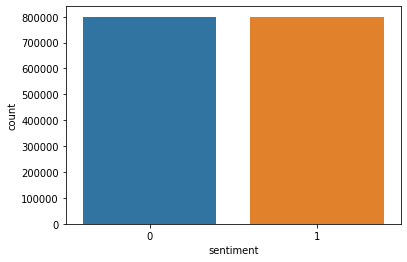

In [ ]:
# plotting the data using countplot
sns.countplot(x="sentiment",data=df)

In [ ]:
#creating a string of positive tweets to analyze the words
positive_tweets = df[df['sentiment'] == 1]['text'].tolist()
positive_tweets_string = " ".join(positive_tweets)

# to see fig uncomment this
# plt.figure(figsize=(15,15))
# plt.imshow(WordCloud().generate(positive_tweets_string))

In [ ]:
# creating the string of negative tweets to analyze the words
negative_tweets = df[df['sentiment'] == 0]['text'].tolist()
negative_tweets_string = " ".join(negative_tweets)


# to see fig uncomment this
# plt.figure(figsize=(15,15))
# plt.imshow(WordCloud().generate(negative_tweets_string))

**2. Prepossessing the Dataset**

In [ ]:
data=df[['text','sentiment']]

data['sentiment'].unique()

array([0, 1])

In [ ]:
# Separating positive and negative tweets
data_pos = data[data['sentiment'] == 1]
data_neg = data[data['sentiment'] == 0]

# taking one fourth data so we can run on our machine easily
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

# Combining positive and negative tweets
dataset = pd.concat([data_pos, data_neg])

# Making statement text in lower case
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [ ]:
# Defining set containing all stopwords in English
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [ ]:
# Cleaning and removing the above stop words list from the tweet text
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [ ]:
# Cleaning and removing punctuations
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [ ]:
# Cleaning and removing repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [ ]:
# Cleaning and removing URL’s
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [ ]:
# Cleaning and removing Numeric numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [ ]:
# Getting tokenization of tweet text
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

In [ ]:
#  Applying Stemming

import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

In [ ]:
# Applying Lemmatizer
nltk.download('omw-1.4')
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

In [ ]:
# Separating input feature and label

data_pos = data[data['sentiment'] == 1]
data_neg = data[data['sentiment'] == 0]

data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

# Combining positive and negative tweets
dataset1 = pd.concat([data_pos, data_neg])


X=dataset1.text
y=dataset1.sentiment




# data.text


In [ ]:
# Plot a cloud of words for negative tweets
data_neg = dataset['text'][:20000]

# to see fig uncomment this
# plt.figure(figsize = (20,20))
# wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
#                collocations=False).generate(" ".join(data_neg))
# plt.imshow(wc)

In [ ]:
# Plot a cloud of words for positive tweets
data_pos = dataset['text'][800000:820000]

# to see fig uncomment this
# wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
#               collocations=False).generate(" ".join(data_pos))
# plt.figure(figsize = (20,20))
# plt.imshow(wc)

**3. Feature Extraction**

In [ ]:
print(X)

800000         I LOVE @Health4UandPets u guys r the best!! 
800001    im meeting up with one of my besties tonight! ...
800002    @DaRealSunisaKim Thanks for the Twitter add, S...
800003    Being sick can be really cheap when it hurts t...
800004      @LovesBrooklyn2 he has that effect on everyone 
                                ...                        
19995     Not much time off this weekend, work trip to M...
19996                             One more day of holidays 
19997     feeling so down right now .. i hate you DAMN H...
19998     geez,i hv to READ the whole book of personalit...
19999     I threw my sign at donnie and he bent over to ...
Name: text, Length: 40000, dtype: object


**4. Splitting Feature in Training and Testing**

In [ ]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state =26105111)

In [ ]:

from sklearn.feature_extraction.text import CountVectorizer
 
# document = ["One Geek helps Two Geeks",
#             "Two Geeks help Four Geeks",
#             "Each Geek helps many other Geeks at GeeksforGeeks"]
 
# # Create a Vectorizer Object
# vectorizer = CountVectorizer()
 
# vectorizer.fit(document)
 
# # Printing the identified Unique words along with their indices
# print("Vocabulary: ", vectorizer.vocabulary_)
 
# # Encode the Document
# vector = vectorizer.transform(document)
 
# # Summarizing the Encoded Texts
# print("Encoded Document is:")
# print(vector.toarray())
vectorizer = CountVectorizer(ngram_range=(1,2), stop_words=stopwordlist)

# print(dataset['text'][0])

# data1 = dataset['text']
# data_vector = data1.iloc[1000:2000] #bcoz dataset is huge



# print(data_vector)
vectorizer.fit(X_train)
vectorizer.fit(X_test)


# for i in data_vector:
#   vectorizer.fit(i)
#   vector = vectorizer.transform(i)
print("Vocabulary: ", vectorizer.vocabulary_)
# print("Encoded Document is:")
# print(vector.toarray())


Vocabulary:  {'sachiclayton': 46218, 'welcome': 60026, 'home': 25194, 'love': 32281, 'sach': 46217, 'sachiclayton welcome': 46219, 'welcome home': 60044, 'home love': 25251, 'love sach': 32430, 'reneasaurus': 45061, 'either': 16178, 'day': 13177, 'works': 61523, 'reneasaurus either': 45062, 'either day': 16182, 'day works': 13434, 'jelly': 27924, 'beans': 5413, 'easter': 15905, 'basket': 5254, 'jelly beans': 27925, 'beans easter': 5414, 'easter basket': 15907, 'brucewayne34': 7573, 'agreed': 1933, 'last': 29924, 'tweet': 56835, 'people': 41074, 'don': 14891, 'understand': 57570, 'life': 30707, 'control': 11525, '99': 1214, 'time': 54927, 'brucewayne34 agreed': 7574, 'agreed last': 1934, 'last tweet': 29965, 'tweet people': 56864, 'people don': 41105, 'don understand': 14984, 'understand life': 57576, 'life control': 30718, 'control 99': 11526, '99 time': 1217, 'karmadillo': 28723, 'no': 37910, 'bad': 4901, 'not': 38383, 'bought': 7011, 'single': 48927, 'egg': 16138, 'yet': 62691, 'fami

In [ ]:

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
import numpy as np

def model_Evaluate(model):
# Predict values for Test dataset
  y_pred = model.predict(X_test)
  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

# **Multinomial Naive Bayes**

              precision    recall  f1-score   support

           0       0.75      0.74      0.75      3972
           1       0.75      0.76      0.75      4028

    accuracy                           0.75      8000
   macro avg       0.75      0.75      0.75      8000
weighted avg       0.75      0.75      0.75      8000

Accuracy: 0.74975
Precision: 0.746712128592304
Recall: 0.7611717974180735


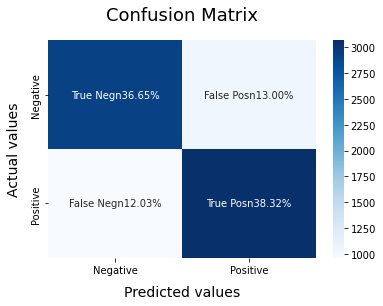

In [ ]:
# X_train.reshape(1,-1)
# BNBmodel = BernoulliNB()
# BNBmodel.fit(X_train, y_train)
# model_Evaluate(BNBmodel)
# y_pred1 = BNBmodel.predict(X_test)
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

# X_train.reshape(1,-1)
model =  MultinomialNB()

model.fit(X_train, y_train)
y1 = model.predict(X_test)


model_Evaluate(model)
# model_Evaluate(model)
print("Accuracy:",metrics.accuracy_score(y_test, y1))
print("Precision:",metrics.precision_score(y_test, y1))
print("Recall:",metrics.recall_score(y_test, y1))

# **5. Decision Tree Classifier**

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      3972
           1       0.70      0.66      0.68      4028

    accuracy                           0.68      8000
   macro avg       0.68      0.68      0.68      8000
weighted avg       0.68      0.68      0.68      8000

Accuracy: 0.68375
Precision: 0.6960732984293194
Recall: 0.6601290963257199


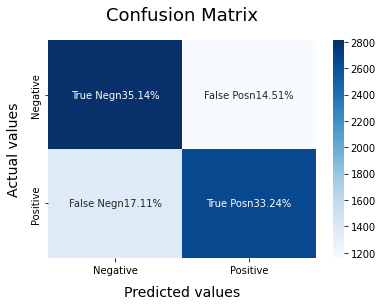

In [ ]:
#take subset of sample i.e. 20,000 samples and train dtc

# X=dataset.text
# y=dataset.sentiment

# # Separating the 95% data for training data and 5% for testing data
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state =97)


from sklearn import metrics
dtc = DecisionTreeClassifier()


dtc = dtc.fit(X_train, y_train)

model_Evaluate(dtc)

y_pred = dtc.predict(X_test)

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))